# Classifying Tweets by Sentiment


### Problem 4: Natural Language Processing (NLP)
If you choose this option, you'll build an NLP model to analyze Twitter sentiment about Apple and Google products. The dataset comes from CrowdFlower via data.world (Links to an external site.). Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

Your task is to:

Build a model that can rate the sentiment of a Tweet based on its content.

#### Aim for a Proof of Concept
There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix.

#### Evaluation
Evaluating multiclass classifiers can be trickier than binary classifiers because there are multiple ways to mis-classify an observation, and some errors are more problematic than others. Use the business problem that your NLP project sets out to solve to inform your choice of evaluation metrics.

# Introduction

In this investigation, as stated above, we will be buliding a Natural Language Processing Model to analyze Tweet/Twitter sentiment (predicting both overall customer base sentiment and individual tweet sentiment?). 
We need to build a model that can:
- Rate the sentiment of a Tweet based on its content.
    - Rate suggests that we should have a scale of classes that we can throw tweets into, then maybe see where the positive, negative tweets fall on that scale accdn. to our model, and then incorporating our neutral classed tweets for a tuning method. 
    - Sentiment suggests we are attempting to measure happiness, but specifically the happiness of those who are tweeting about either Apple or Google products. Our dataset is provided with classifications Positive, Neutral, and Negative, which is as far as we need to proceed according to the task provided. 
       - Something interesting would be a regression task which scales tweets' sentiment from 0 to 10 and we construct the net promoter score for apple products vs iphone products, comparing these two companies in a really interpretable way. 
   - Content of the tweet needs to also be broken down. How will we define the content? We can construct our data for modelling from our tweets 'content' by:
       - Feature Engineering ; each of these gives a different 'perspective' on words whether looking context or content. 
           - Bigrams & Mutual Information Score
           - Parts Of Speech Tags
           - Word2Vec engineering 
           
Now that we have fully parsed out all the possible interpretations of our task, let us begin with investigating our data. 
           

In [100]:
!pip install -U fsds

Requirement already up-to-date: fsds in c:\users\rmcar\anaconda\envs\learn-env\lib\site-packages (0.2.27)


In [101]:

from fsds.imports import * 
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np

In [102]:
rawdf = pd.read_csv("data/NLP_dataset.csv", encoding= 'unicode_escape')

In [103]:
# we inspect the columns

rawdf.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [104]:
# we rename columns

rename_dict = {"tweet_text" : 'text',
              'emotion_in_tweet_is_directed_at' : 'product',
              'is_there_an_emotion_directed_at_a_brand_or_product' : 'sentiment'}

rawdf = rawdf.rename(columns = rename_dict)

In [105]:
# we check possible values for product

rawdf['product'].value_counts(dropna = False)


# of the 9093 tweets in our dataset, 5802 tweets did not have a particular product in mention.

NaN                                5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: product, dtype: int64

In [106]:
# we also check possible values for sentiment

rawdf['sentiment'].value_counts(dropna = False)

# let's rename these to reflect the three possible classes we need to target: Positive, Negative, Neutral

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [107]:
# we investigate 'I can't tell' class

cant_tell_df = rawdf.where(rawdf['sentiment'] == "I can't tell").dropna().reset_index()

for i in range(len(cant_tell_df)):
    
    print(cant_tell_df['text'][i])
    
# most of these tweets look neutral, for some reason these were encoded differently than 'no emotion toward brand or product'
# we will treat these as 'neutral'

I won't be at #sxsw and I won't be in line to buy iPad 2.0 tomorrow. #notwinning.
I am neither at #SXSW nor buying an iPad 2 today. I feel like my geek cred is basically gone.
I feel like my iPhone: Always on, always doing something, running out of battery fast. #sxsw
RT @mention Design for iPad is like design 101. Will someone give a talk and assume that we didn't all ditch our prev experience #sxsw
Google should put those engineers formerly behind real estate listings into renewing the Google Checkout project. #SXSW
Google maps used to provide common reference points and printed for fast paced on the ground reactions #arabspring #SXSW
At the airport playing my fav game:  &quot;Are You Going to #SXSW?&quot; Wearing denim on denim? You're going.  Charging 3+ Apple products? You too.
Geez #sxsw people are eating this up. Another line outside the apple store for iPad 2 in austin {link}
How much you want to bet Apple is disproportionately stocking the #SXSW pop-up store with iPad 2? The i

In [108]:
def sentiment_cleaner(df, column):
    sentiment_list = []
    for i in df[column]:
        if i == "No emotion toward brand or product":
            sentiment_list.append('neutral')
        elif i == "I can't tell":
            sentiment_list.append('neutral')
        elif i == "Positive emotion":
            sentiment_list.append('positive')
        elif i == "Negative emotion":
            sentiment_list.append('negative') 
    df['eng_sentiment'] = sentiment_list
    return df


In [109]:
# we clean the sentiment column

rawdf = sentiment_cleaner(rawdf, 'sentiment')

rawdf['product_isna'] = rawdf['product'].isna()

# and check our target class

rawdf['eng_sentiment'].value_counts(dropna = False)

# strong class imbalance of 1.86 : 1.00 : 0.19, neutral : positive : negative

neutral     5545
positive    2978
negative     570
Name: eng_sentiment, dtype: int64

In [110]:
product_nan = rawdf.where(rawdf['product_isna'] == True)

product_nan = product_nan.drop(columns = 'product')

no_product = product_nan.dropna()

In [111]:
# we check value counts for tweets that have no identified product. 

no_product.reset_index()

no_product['eng_sentiment'].value_counts() 

# where there is no product, 5444 are neutral, 306 positive, 51 negative. 


neutral     5444
positive     306
negative      51
Name: eng_sentiment, dtype: int64

# Natural Language Preprocessing
 - Stop Words
 - Stem or Lemmatization?
 - Tokenization through regex?
 - Full vocab or word subset?
 - Bigrams, pos, mis?
 - Word2Vec

Lemmatization, Stemming, and Stop Word Removal

In [112]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rmcar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [113]:
df = rawdf.copy()
df = df.drop(columns = 'product_isna')

In [114]:
# we define a list of all tweets

full_text = df['text'].to_list()
full_text[:10]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd',
 nan,
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.l

In [115]:
# we build our bag of words

bag = ','.join(map(str, full_text))
bag

".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.,@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress),@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,nan,#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,Counting down the days

In [118]:
# we complete basic tokenization


tokens = word_tokenize(bag)
frequency_list = FreqDist(tokens)

tokens



['.',
 '@',
 'wesley83',
 'I',
 'have',
 'a',
 '3G',
 'iPhone',
 '.',
 'After',
 '3',
 'hrs',
 'tweeting',
 'at',
 '#',
 'RISE_Austin',
 ',',
 'it',
 'was',
 'dead',
 '!',
 'I',
 'need',
 'to',
 'upgrade',
 '.',
 'Plugin',
 'stations',
 'at',
 '#',
 'SXSW.',
 ',',
 '@',
 'jessedee',
 'Know',
 'about',
 '@',
 'fludapp',
 '?',
 'Awesome',
 'iPad/iPhone',
 'app',
 'that',
 'you',
 "'ll",
 'likely',
 'appreciate',
 'for',
 'its',
 'design',
 '.',
 'Also',
 ',',
 'they',
 "'re",
 'giving',
 'free',
 'Ts',
 'at',
 '#',
 'SXSW',
 ',',
 '@',
 'swonderlin',
 'Can',
 'not',
 'wait',
 'for',
 '#',
 'iPad',
 '2',
 'also',
 '.',
 'They',
 'should',
 'sale',
 'them',
 'down',
 'at',
 '#',
 'SXSW.',
 ',',
 '@',
 'sxsw',
 'I',
 'hope',
 'this',
 'year',
 "'s",
 'festival',
 'is',
 "n't",
 'as',
 'crashy',
 'as',
 'this',
 'year',
 "'s",
 'iPhone',
 'app',
 '.',
 '#',
 'sxsw',
 ',',
 '@',
 'sxtxstate',
 'great',
 'stuff',
 'on',
 'Fri',
 '#',
 'SXSW',
 ':',
 'Marissa',
 'Mayer',
 '(',
 'Google',
 ')',


In [119]:
# we lemmatize and stem our bag of words

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')

def lemmer(bag):
    
    lemmatizer = WordNetLemmatizer()

    lem_bag = []
    
    for word in bag:

        lemmed_word = lemmatizer.lemmatize(word)
        lem_bag.append(lemmed_word)
        
    return lem_bag

lemmed_bag = lemmer(tokens)

def stemmer(bag):
    
    stemmer = PorterStemmer()    
    
    stem_bag = []

    for word in bag:
    
        stem_bag.append(stemmer.stem(word))
        
    return stem_bag

stemmed_bag = stemmer(lemmed_bag)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rmcar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [120]:
# we construct a stopword list using NLTK and remove them from our bag of words.  

nltk.download('stopwords')

stops = (stopwords.words('english') +
        list(string.punctuation) +
        ['“','”','...',"''",'’','``'] +
         []) # removing instances of 'rt' which stands for retweet


def stopper(bag, stops = stops):
    
    stop_bag = [word.lower() for word in bag if word.lower() not in stops]
    
    return stop_bag

clean_bag = stopper(stemmed_bag)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rmcar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
# we check frequencies of words in our new bag cleaned of stopwords

frequency = FreqDist(clean_bag)
frequency.most_common(100)

# we need to add additional stopwords to our stopwords list, stem our bag of words, as well as address digits in our bag. 
# furthermore, the existence of instances such as "n't", "'re", "'s'", and other suggest we need to add to our stopwords list. 

[('sxsw', 9418),
 ('mention', 7130),
 ('link', 4329),
 ('rt', 2962),
 ('googl', 2598),
 ('ipad', 2520),
 ('appl', 2304),
 ('quot', 1702),
 ('iphon', 1523),
 ('store', 1511),
 ("'s", 1236),
 ('2', 1146),
 ('new', 1127),
 ('app', 1034),
 ('austin', 960),
 ('launch', 838),
 ('amp', 836),
 ('circl', 673),
 ('social', 650),
 ('thi', 613),
 ('android', 574),
 ('today', 574),
 ('open', 533),
 ('get', 529),
 ('network', 487),
 ("n't", 482),
 ('ipad2', 471),
 ('line', 453),
 ('go', 445),
 ('pop-up', 422),
 ('via', 413),
 ('call', 403),
 ('parti', 392),
 ('free', 387),
 ('mobil', 341),
 ('sxswi', 340),
 ('come', 331),
 ('like', 324),
 ('ha', 313),
 ('time', 312),
 ('one', 312),
 ('major', 306),
 ('use', 304),
 ('win', 299),
 ('map', 277),
 ("'re", 265),
 ('temporari', 264),
 ('day', 263),
 ('check', 259),
 ('possibl', 255),
 ("'m", 254),
 ('see', 254),
 ('u', 249),
 ('need', 248),
 ('wa', 246),
 ('look', 234),
 ('design', 233),
 ('make', 227),
 ('peopl', 226),
 ('downtown', 225),
 ('great', 222)

In [122]:
# we remove some additional stopwords before continuing with our preprocessing. 

stops = (stopwords.words('english') +
        list(string.punctuation) +
        ['“','”','...',"''",'’','``'] +
         ['rt', "'s", "n't", "'re", "'m", "\x89ûï"]) # making manual additions to stopwords list

# there are 2962 instances of 'rt' in our bag of words. Because a retweet can be of a retweet (meaning it would show as
# RT(RT 'text')), this means that there is at most 2962 retweets of the 9093 tweets, or 32.57% of our dataset. 
# we should definitely complete an investigation of retweets, to show how they may affect or skew our data. 
# something to consider would be dropping retweets in favor of original content. 


In [124]:
# we complete preprocessing on our dataframe to gain columns to reflect: cleaned bag of words, length of text, 

0.32574507863191465

## Exploratory Data Analysis

In [241]:
!pip install wordcloud

(-0.5, 399.5, 199.5, -0.5)

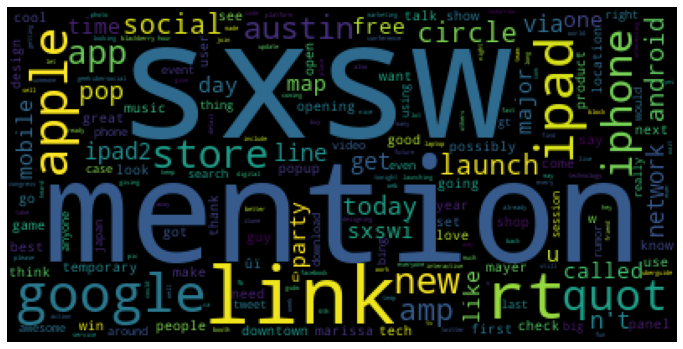

In [242]:
# we plot a basic wordcloud to gain a basic visualization

from wordcloud import WordCloud

## Initalize a WordCloud with our stopwords_list and no bigrams
wordcloud = WordCloud(stopwords=stops,collocations=False)

## Generate wordcloud from stopped_tokens
wordcloud.generate(','.join(stops_tokens))

## Plot with matplotlib
plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

In [93]:
# we investigate distrubution of tweet length

text_lengths = []

for i in range(len(df)):
    length = len(df['text'][i])
    text_lengths.append(length)
df['text_len'] = text_lengths

    

TypeError: object of type 'float' has no len()

In [90]:
df

,text,product,sentiment,eng_sentiment,text_len
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,negative,9093
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,positive,9093
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,positive,9093
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,negative,9093
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,positive,9093
...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,positive,9093
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,neutral,9093
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,neutral,9093
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,neutral,9093


ConversionError: Failed to convert value(s) to axis units: 0                   iPhone
1       iPad or iPhone App
2                     iPad
3       iPad or iPhone App
4                   Google
               ...        
9088                  iPad
9089                   NaN
9090                   NaN
9091                   NaN
9092                   NaN
Name: x, Length: 9093, dtype: object

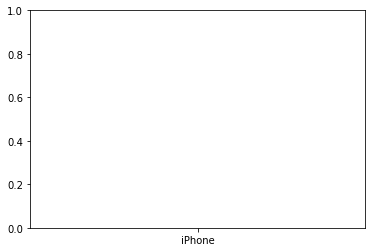

In [95]:
# we visualize number of tweets by product

sns.histplot(data = df, x = 'product')
plt.show()

In [ ]:
# we visualize number of tweets by sentiment